In [1]:
# environment: Paperspace Quadro P6000 GPU  
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf
import tensorflow.keras # run pip install keras==2.3 beforehand for compatability 
from tensorflow.keras import Input, Model 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, AlphaDropout, MaxPooling2D, AveragePooling2D, BatchNormalization, Concatenate, Flatten, Reshape, Add, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.transform import warp, AffineTransform
from skimage.transform import resize
import cv2
import random 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle # shuffle dataset before splitting into folds 
from scipy.ndimage.filters import gaussian_filter # for elastic distortion 
from scipy.ndimage.interpolation import map_coordinates # for elastic distortion 
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model 
import numpy as np 
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
# generator model 
generator = Sequential() 
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2))) 
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128))) 
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same')) 
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh')) 

In [3]:
# discriminator model 
discriminator = Sequential() 
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28,28,1), padding = 'same')) 
discriminator.add(Activation(LeakyReLU(0.2))) 
discriminator.add(Dropout(0.3)) 
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2))) 
discriminator.add(Dropout(0.3)) 
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid')) 
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam') 
discriminator.trainable = False 

In [4]:
ginput = Input(shape = (100,))

dis_output = discriminator(generator(ginput)) 
gan = Model(ginput, dis_output) 
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam') 
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [5]:
train = pd.read_csv('./storage/modified_mnist_dataset/train.csv'  )
test = pd.read_csv('./storage/modified_mnist_dataset/test.csv') 
submission = pd.read_csv('./storage/modified_mnist_dataset/submission.csv')  

In [6]:
train_df = train.values 

In [7]:
# get all images from train set with label 1 
X_train = [] 
for i in range(len(train_df)): 
    if train_df[i,1] == 1: 
        X_train.append(train_df[i,3:]) 
X_train = np.asarray(X_train)
X_train = X_train.reshape((-1,28,28,1)).astype(np.float32) 

In [8]:
generated = [] 



def gan_train(epoch, batch_size, saving_interval,X_train): 
    X_train = (X_train - 127.5)/127.5 
    real = np.ones((batch_size, 1))  
    fake = np.zeros((batch_size, 1))  
    for i in range(epoch): 
        # enter real image into discriminator 
        idx = np.random.randint(0, X_train.shape[0], batch_size) 
        imgs = X_train[idx] 
        d_loss_real = discriminator.train_on_batch(imgs, real) 
        
        # enter fake image into discriminator 
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        gen_imgs = generator.predict(noise) 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 
        
        # calculate the loss 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        g_loss = gan.train_on_batch(noise, real)   
        
        print("epoch: %d" % i, 'd_loss: %.4f' %d_loss, 'g_loss: %.4f' %g_loss) 
        
        if i == epoch-1:  
            noise = np.random.normal(0,1,(198,100)) 
            gen_imgs = generator.predict(noise) 
            gen_imgs = 0.5 * gen_imgs + 0.5  
            for j in range(198):  
                generated.append(gen_imgs[j,:,:,0])
        


In [9]:
gan_train(4501,128,100,X_train)

epoch: 0 d_loss: 0.7275 g_loss: 0.5415
epoch: 1 d_loss: 0.5286 g_loss: 0.2353
epoch: 2 d_loss: 0.4818 g_loss: 0.0694
epoch: 3 d_loss: 0.4828 g_loss: 0.0396
epoch: 4 d_loss: 0.4855 g_loss: 0.0585
epoch: 5 d_loss: 0.4634 g_loss: 0.1402
epoch: 6 d_loss: 0.4450 g_loss: 0.2786
epoch: 7 d_loss: 0.4565 g_loss: 0.3294
epoch: 8 d_loss: 0.4613 g_loss: 0.2581
epoch: 9 d_loss: 0.4470 g_loss: 0.1683
epoch: 10 d_loss: 0.4294 g_loss: 0.1045
epoch: 11 d_loss: 0.3928 g_loss: 0.0782
epoch: 12 d_loss: 0.3318 g_loss: 0.0697
epoch: 13 d_loss: 0.2726 g_loss: 0.0720
epoch: 14 d_loss: 0.2284 g_loss: 0.0379
epoch: 15 d_loss: 0.1883 g_loss: 0.0108
epoch: 16 d_loss: 0.1442 g_loss: 0.0066
epoch: 17 d_loss: 0.1015 g_loss: 0.0096
epoch: 18 d_loss: 0.1273 g_loss: 0.0022
epoch: 19 d_loss: 0.0928 g_loss: 0.0029
epoch: 20 d_loss: 0.1149 g_loss: 0.0026
epoch: 21 d_loss: 0.2078 g_loss: 0.0011
epoch: 22 d_loss: 0.1380 g_loss: 0.0045
epoch: 23 d_loss: 0.4554 g_loss: 0.0032
epoch: 24 d_loss: 0.1753 g_loss: 0.0084
epoch: 25 

In [10]:
generated = np.asarray(generated) 

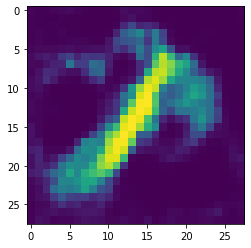

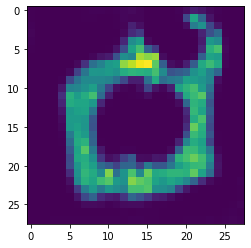

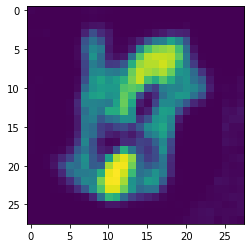

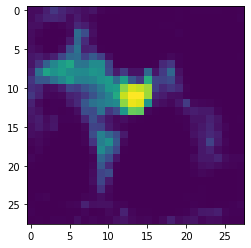

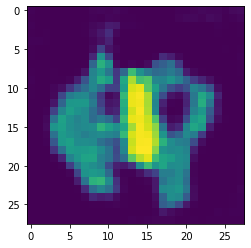

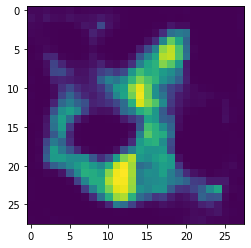

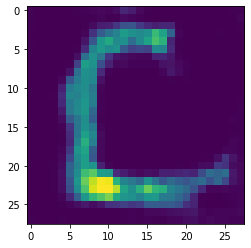

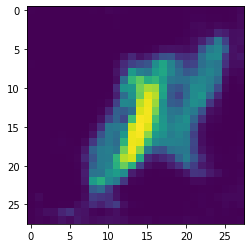

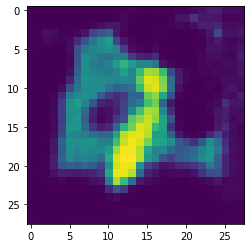

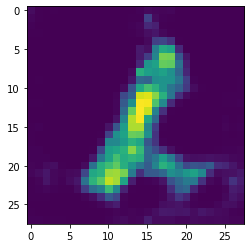

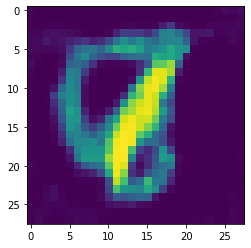

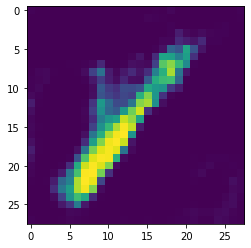

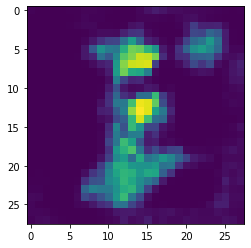

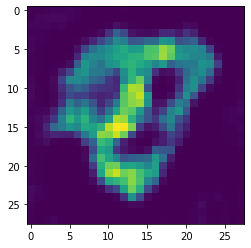

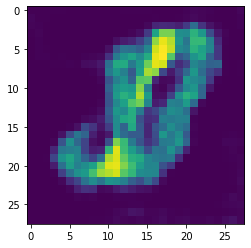

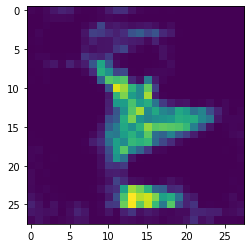

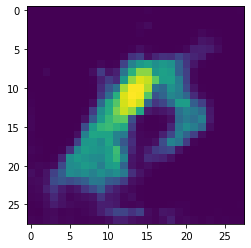

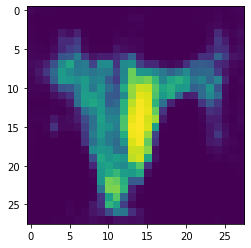

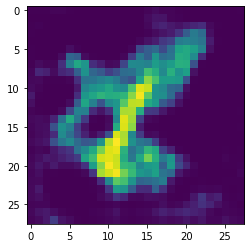

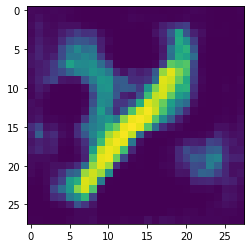

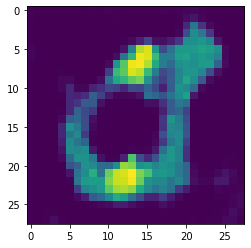

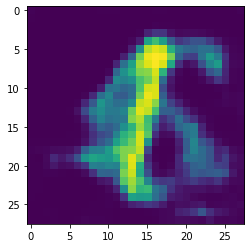

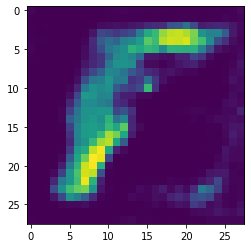

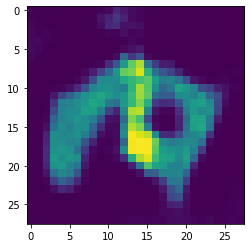

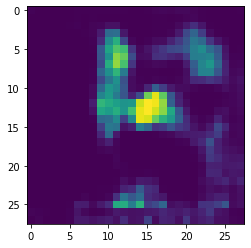

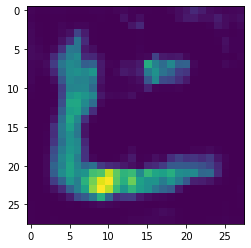

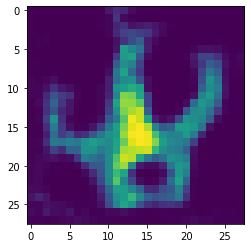

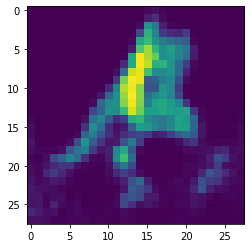

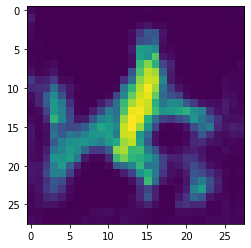

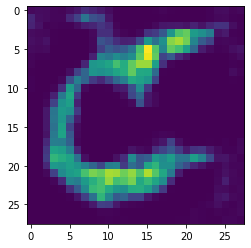

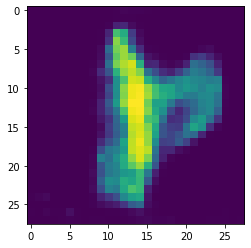

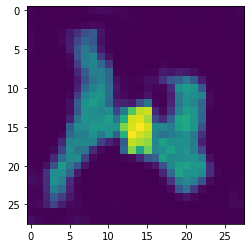

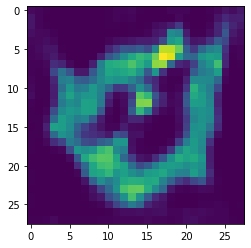

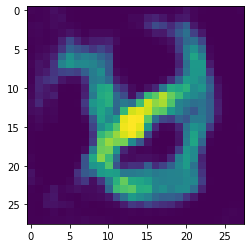

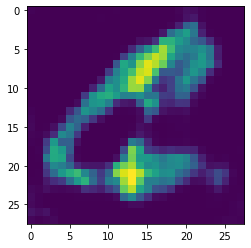

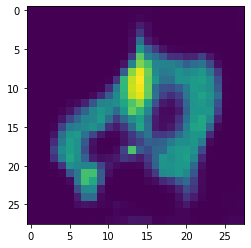

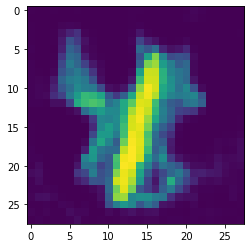

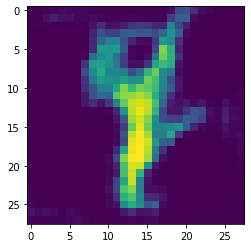

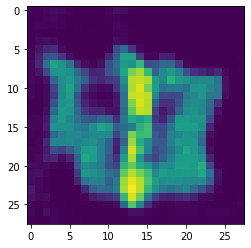

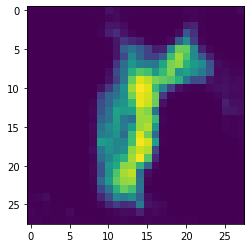

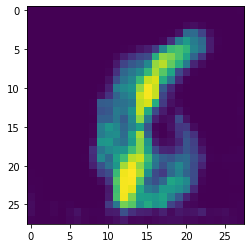

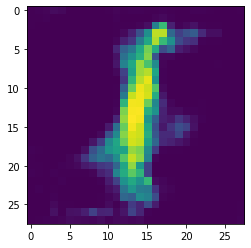

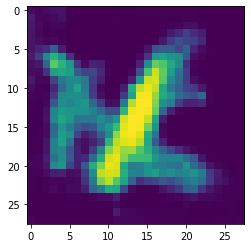

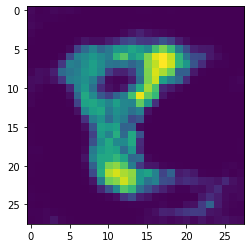

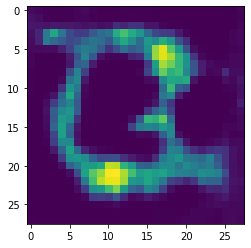

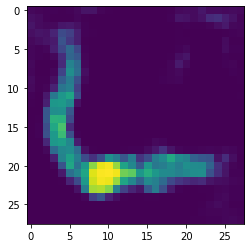

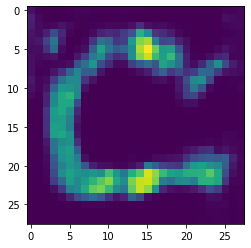

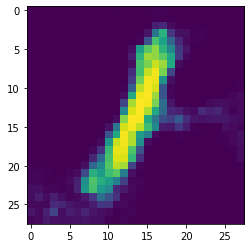

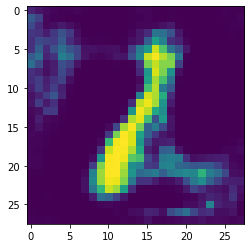

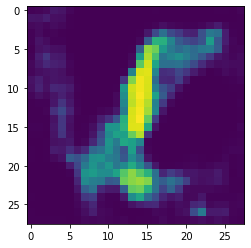

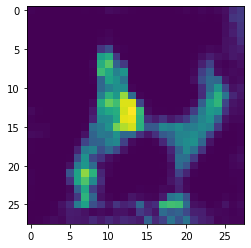

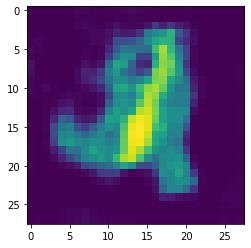

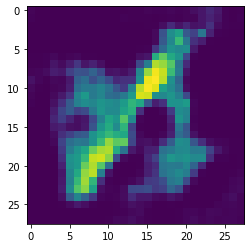

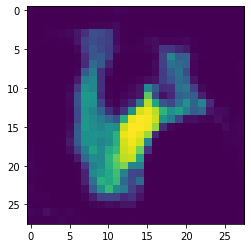

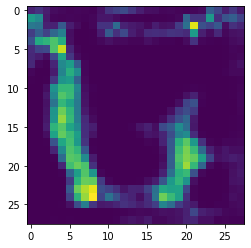

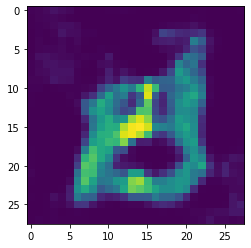

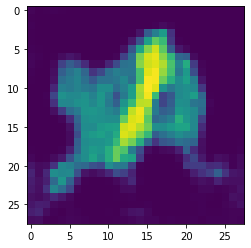

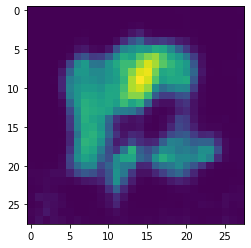

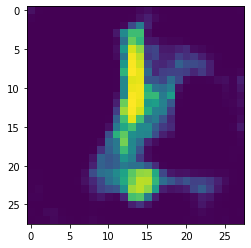

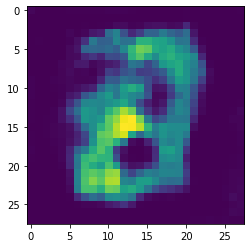

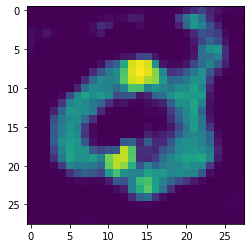

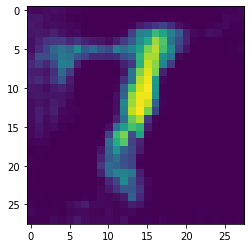

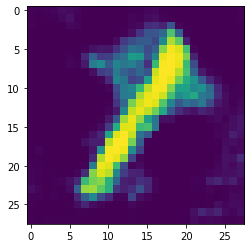

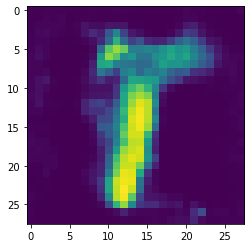

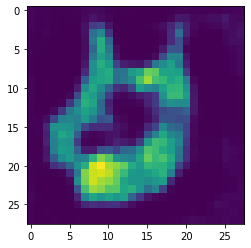

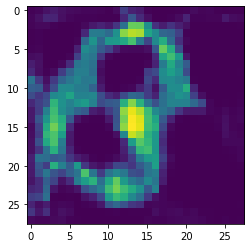

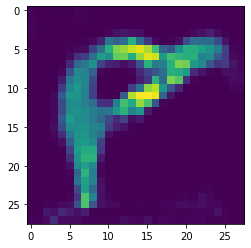

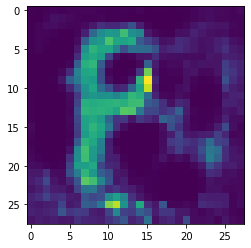

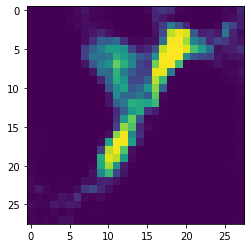

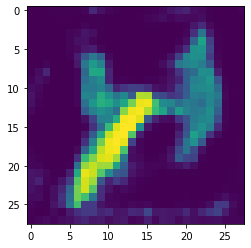

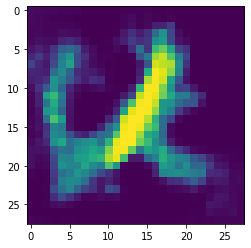

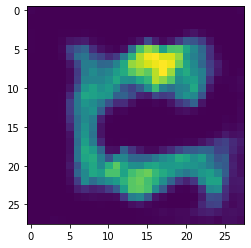

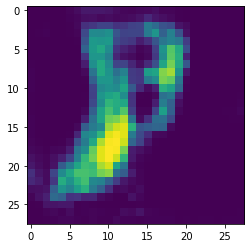

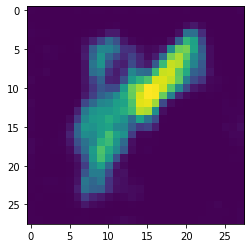

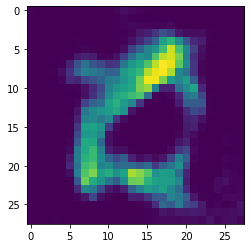

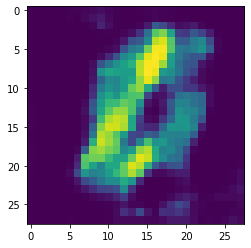

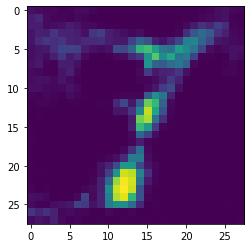

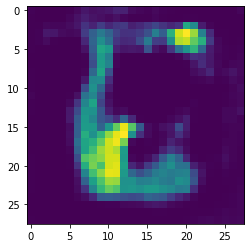

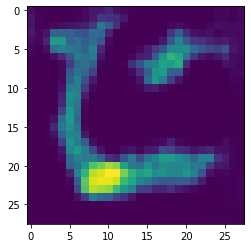

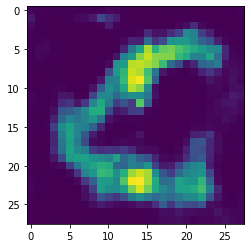

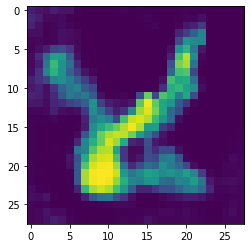

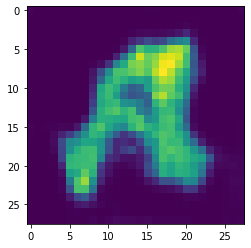

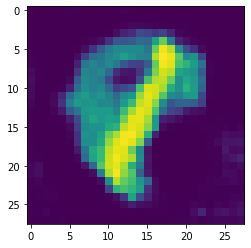

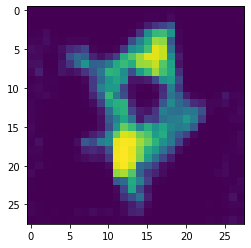

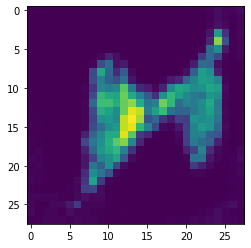

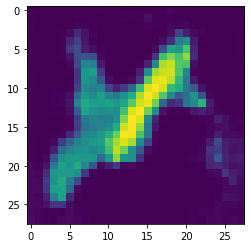

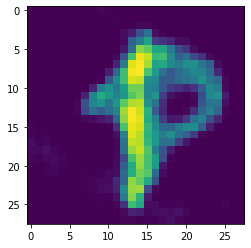

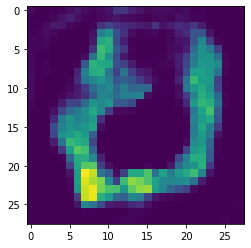

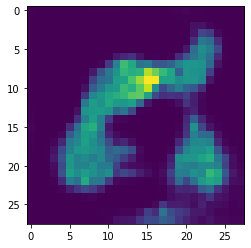

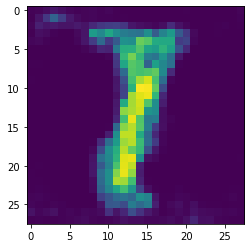

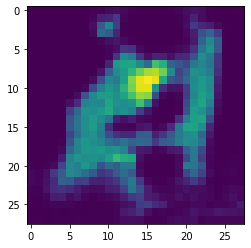

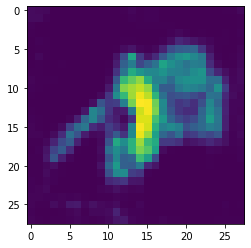

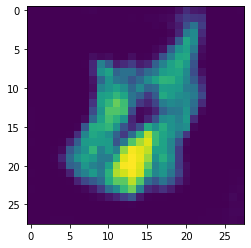

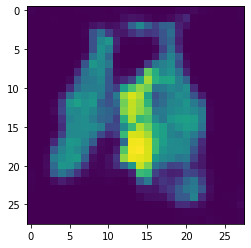

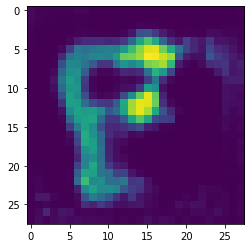

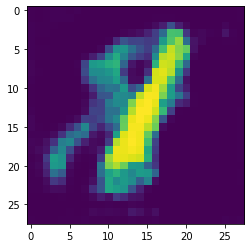

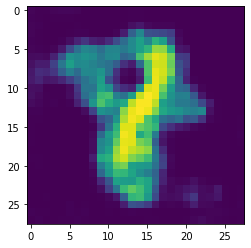

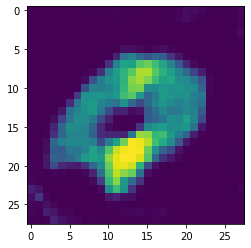

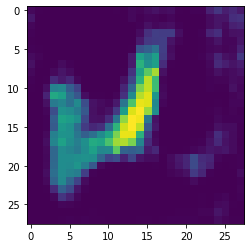

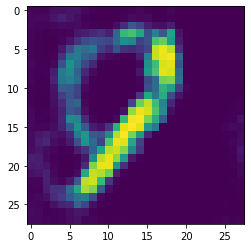

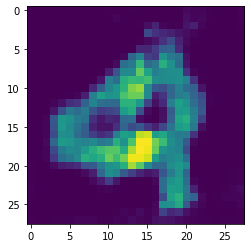

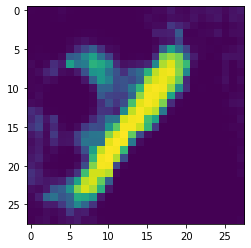

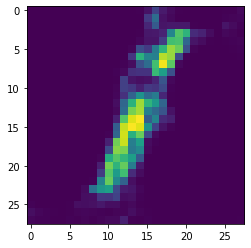

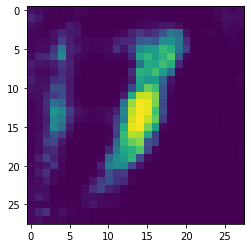

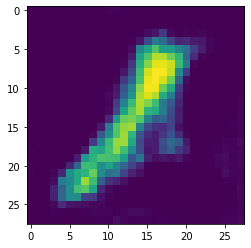

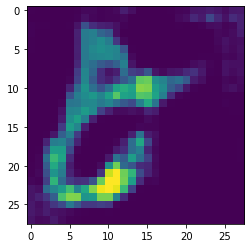

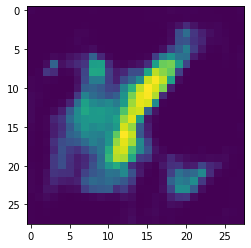

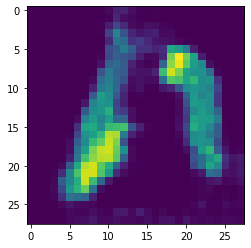

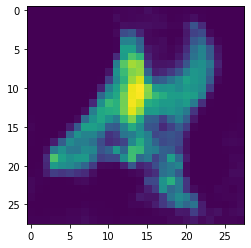

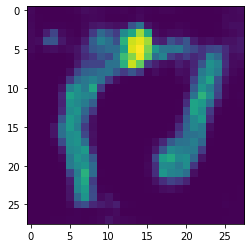

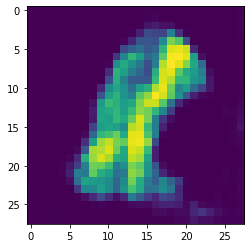

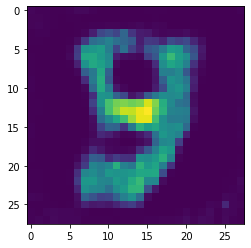

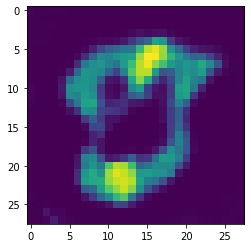

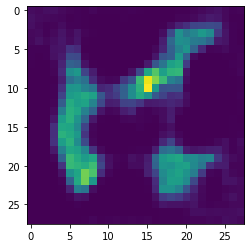

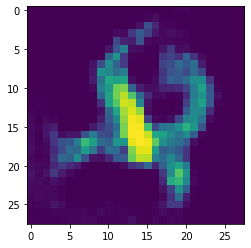

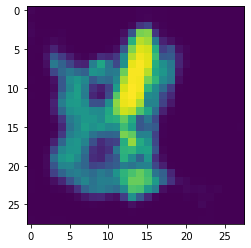

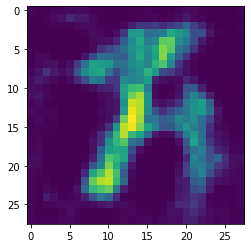

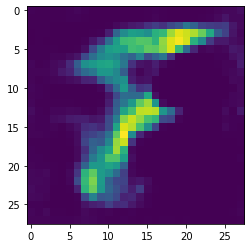

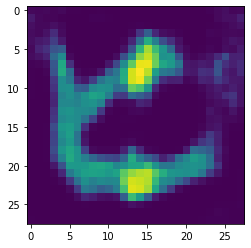

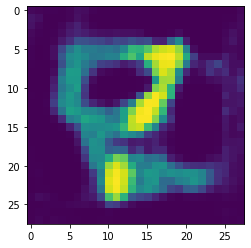

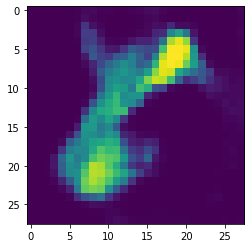

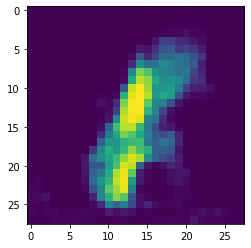

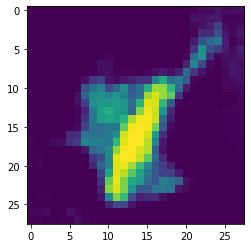

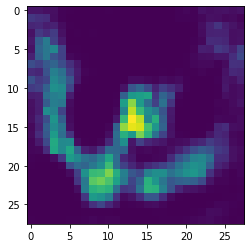

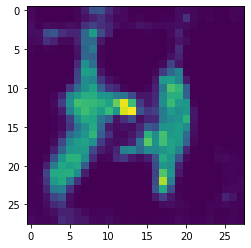

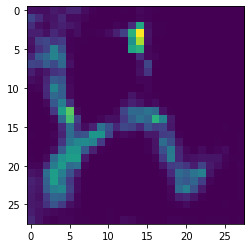

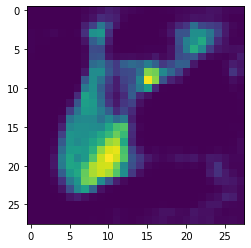

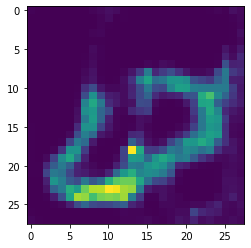

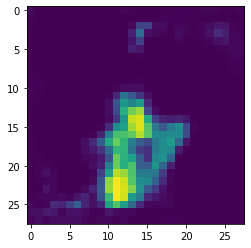

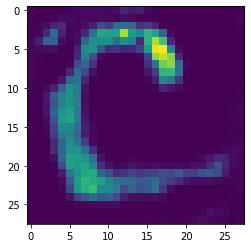

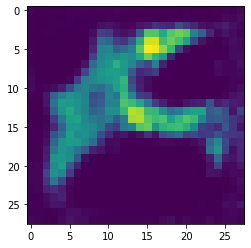

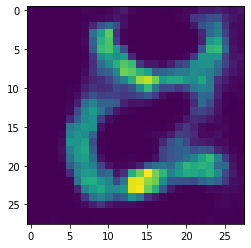

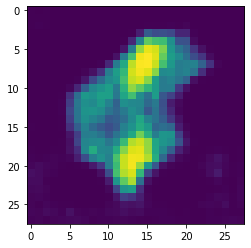

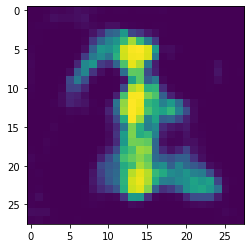

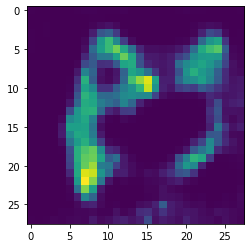

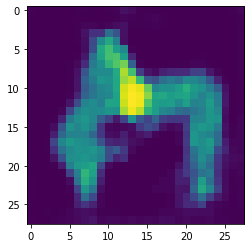

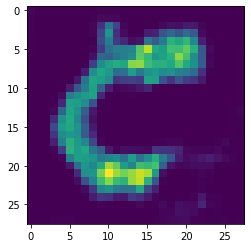

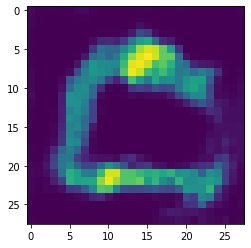

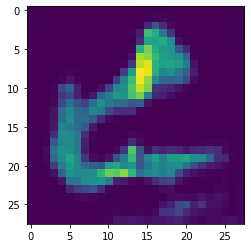

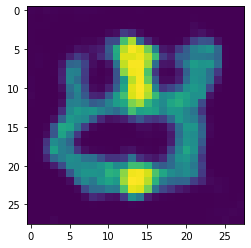

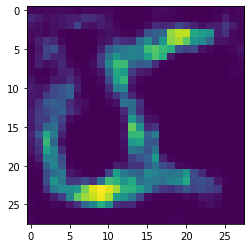

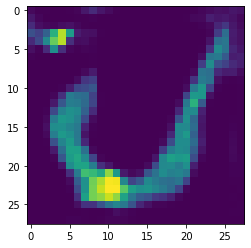

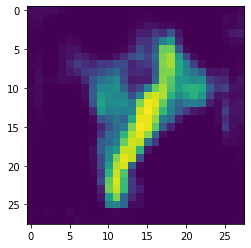

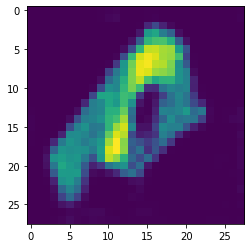

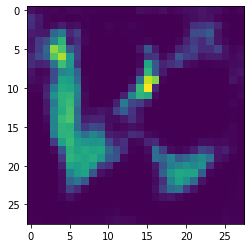

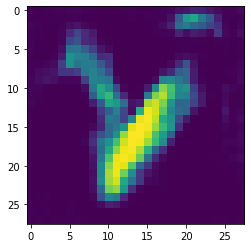

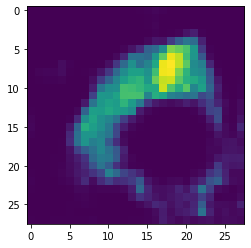

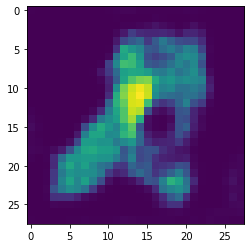

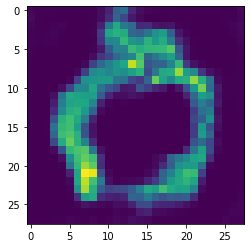

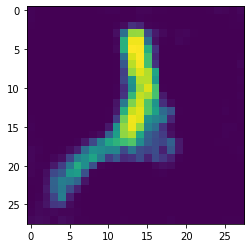

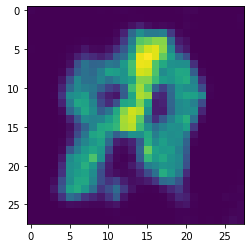

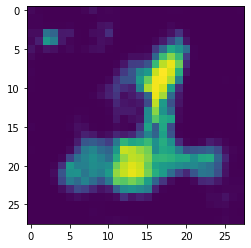

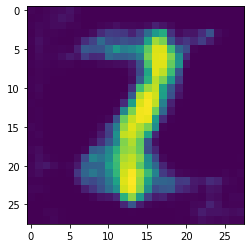

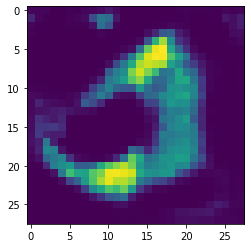

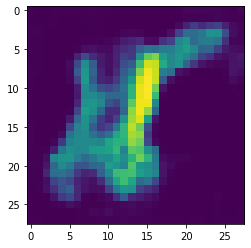

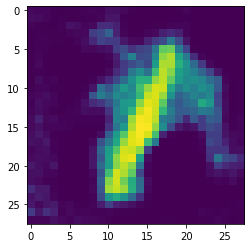

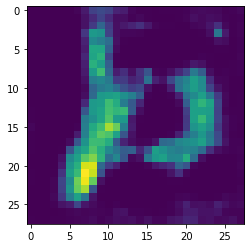

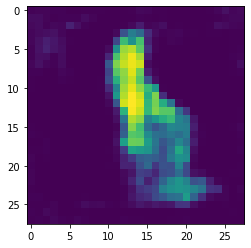

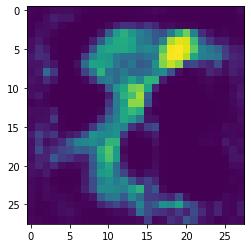

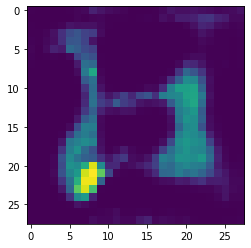

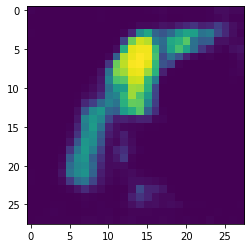

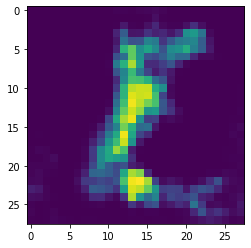

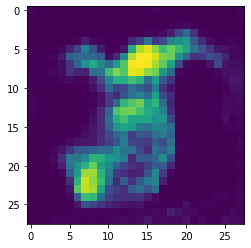

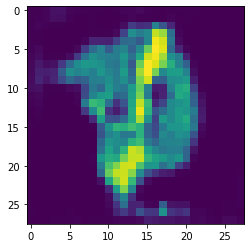

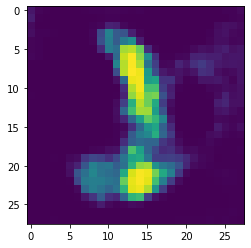

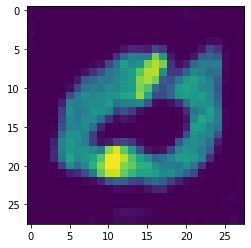

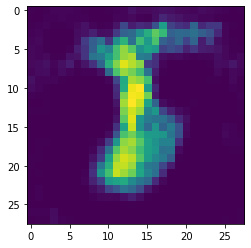

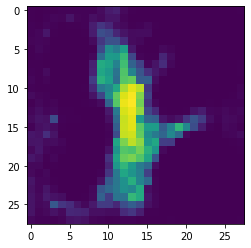

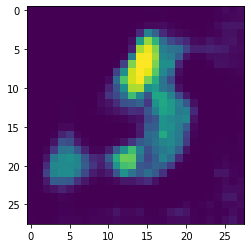

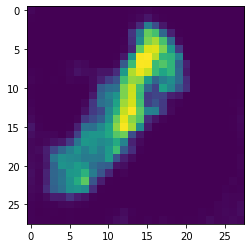

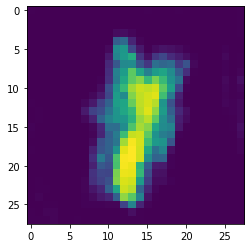

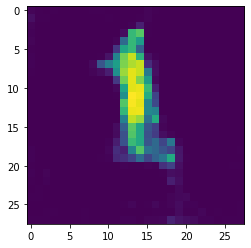

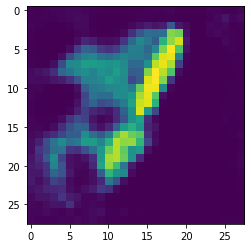

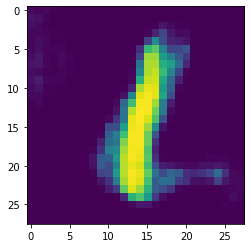

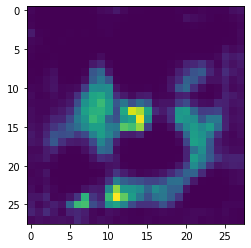

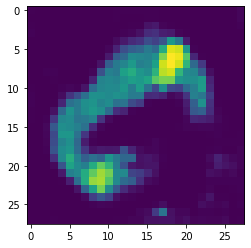

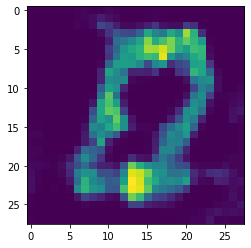

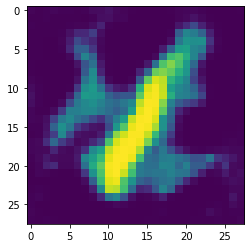

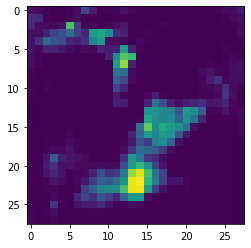

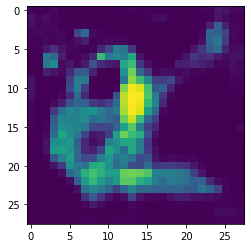

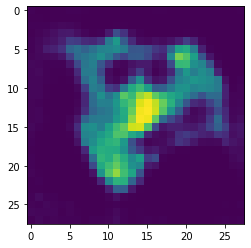

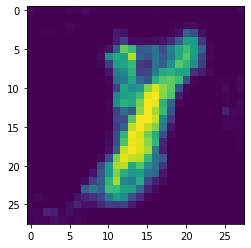

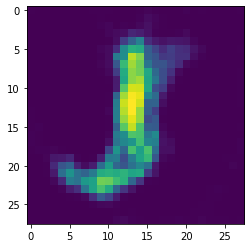

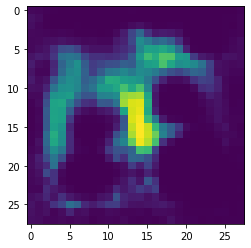

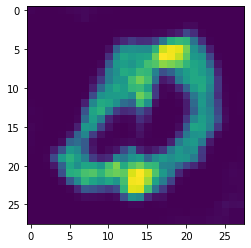

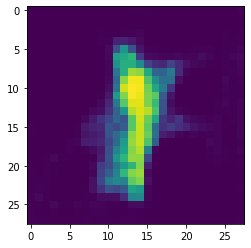

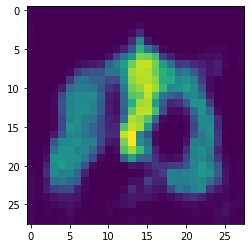

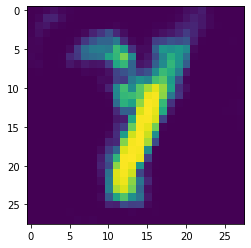

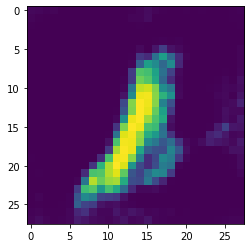

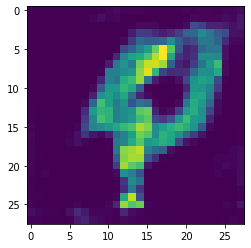

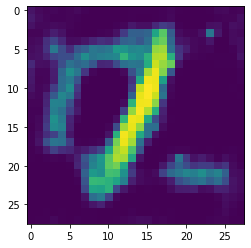

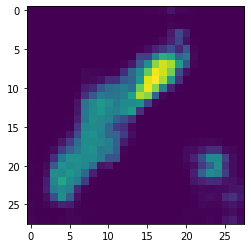

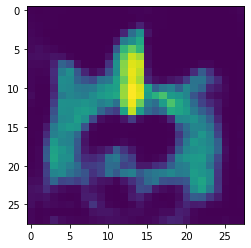

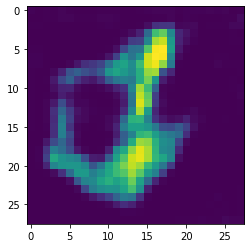

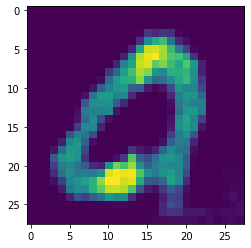

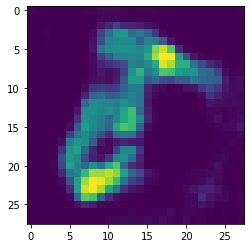

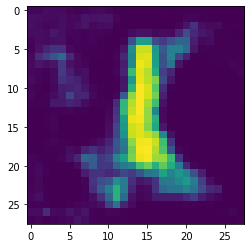

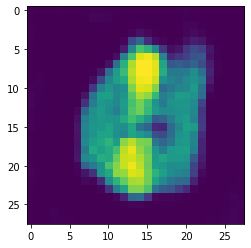

In [11]:
for i in range(len(generated)): 
    plt.figure() 
    plt.imshow(generated[i]) 
    plt.show()